In [5]:
#from __future__ import division, print_function
import matplotlib.pyplot as plt
import bilby
import numpy as np

import time

from bilby.core.prior import Uniform
#from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters
%matplotlib inline

import hphc8

C = 299792458.
G = 6.67408*1e-11
Mo = 1.989*1e30
Mpc = 3.086*1e22

In [6]:
np.random.seed(1234)

In [7]:
outdir = 'outdir_new_model'
label = 'create_your_own_source_model'
sampling_frequency = 1024.0
duration = 2.0

In [8]:
def eccentric_waveform(frequency_array, mass_1, mass_2, eccentricity, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec):
    
    N = len(frequency_array)
    h_plus = np.zeros(N)*1j
    h_cross = np.zeros(N)*1j
    
    fmin = 20.0
    fmax = (C**3)/( G*(mass_1+mass_2)*Mo*np.pi*6**(3/2) )
    
    k = 0
    for f in frequency_array:
        if f>=fmin and f<=fmax:        
            arg_plus = {'iota_':theta_jn, 'beta_':psi, 'D_':luminosity_distance , 'm1_':mass_1, 'm2_':mass_2, 'f_':f, 'f0_':20.0, 'Fp_':1.0, 'Fc_':0.0, 'et0_':eccentricity, 'phic_':phase, 'tc_':geocent_time}

            fplus = hphc8.Fn(**arg_plus)
            
            h_plus[k] = fplus.htilde()[0]
            h_cross[k] = fplus.htilde()[1]
            
        k=k+1

    return {'plus': h_plus, 'cross': h_cross}

In [23]:
# We now define some parameters that we will inject
#injection_parameters = dict(mass_1=35.0, mass_2=30.0, eccentricity=0.1, luminosity_distance=440.0, theta_jn=0.4, psi=0.1, phase=1.2, geocent_time=1180002601.0, ra=45, dec=5.73)
injection_parameters = dict(mass_1=10.0, mass_2=10.0, eccentricity=0.1, luminosity_distance=100.0, theta_jn=1.0471975511965976, psi=1.0471975511965976, phase=0.0, geocent_time=1180002601.0, ra=45, dec=5.73)

In [24]:
# Now we pass our source function to the WaveformGenerator
waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=eccentric_waveform, parameters=injection_parameters)

12:30 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: __main__.eccentric_waveform
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [25]:
minimum_frequency = 20.0+5.0
MM1 = 10.0
MM2 = 10.0
maximum_frequency = (C**3)/( G*(MM1+MM2)*Mo*np.pi*6**(3/2) )-5.0

ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
for ifo in ifos:
    ifo.minimum_frequency = minimum_frequency
    ifo.maximum_frequency = maximum_frequency
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - 1)
ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)


/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
12:30 bilby INFO    : Injected signal in H1:
12:30 bilby INFO    :   optimal SNR = 74.06
12:30 bilby INFO    :   matched filter SNR = 73.31-1.09j
12:30 bilby INFO    :   mass_1 = 10.0
12:30 bilby INFO    :   mass_2 = 10.0
12:30 bilby INFO    :   eccentricity = 0.1
12:30 bilby INFO    :   luminosity_distance = 100.0
12:30 bilby INFO    :   theta_jn = 1.0471975511965976
12:30 bilby INFO    :   psi = 1.0471975511965976
12:30 bilby INFO    :   phase = 0.0
12:30 bilby INFO    :   geocent_time = 1180002601.0
12:30 bilby INFO    :   ra = 45
12:30 bilby INFO    :   dec = 5.73
12:30 bilby INFO    : Injected signal in L1:
12:30 bilby INFO    :   optimal SNR = 43.88
12:30 bilby INFO    :   matched filter SNR = 44.76-0.69j
12:30 bil

[{'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}]

12:31 bilby INFO    : Injected signal in H1:
12:31 bilby INFO    :   optimal SNR = 74.06
12:31 bilby INFO    :   matched filter SNR = 147.37-1.09j
12:31 bilby INFO    :   mass_1 = 10.0
12:31 bilby INFO    :   mass_2 = 10.0
12:31 bilby INFO    :   eccentricity = 0.1
12:31 bilby INFO    :   luminosity_distance = 100.0
12:31 bilby INFO    :   theta_jn = 1.0471975511965976
12:31 bilby INFO    :   psi = 1.0471975511965976
12:31 bilby INFO    :   phase = 0.0
12:31 bilby INFO    :   geocent_time = 1180002601.0
12:31 bilby INFO    :   ra = 45
12:31 bilby INFO    :   dec = 5.73
12:31 bilby INFO    : Injected signal in L1:
12:31 bilby INFO    :   optimal SNR = 43.88
12:31 bilby INFO    :   matched filter SNR = 88.64-0.69j
12:31 bilby INFO    :   mass_1 = 10.0
12:31 bilby INFO    :   mass_2 = 10.0
12:31 bilby INFO    :   eccentricity = 0.1
12:31 bilby INFO    :   luminosity_distance = 100.0
12:31 bilby INFO    :   theta_jn = 1.0471975511965976
12:31 bilby INFO    :   psi = 1.0471975511965976
12:3

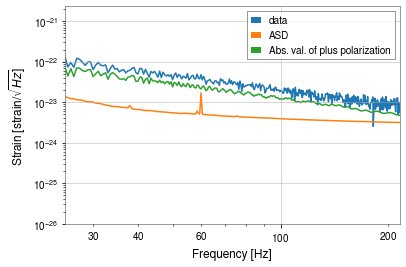

In [26]:
injection = ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)

H1 = ifos[0]
H1_injection = injection[0]

fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]),
          label="data")
ax.loglog(H1.frequency_array[idxs],
          H1.amplitude_spectral_density_array[idxs],
          label="ASD")
ax.loglog(H1.frequency_array[idxs],
          np.abs(H1_injection["plus"][idxs]),
          label="Abs. val. of plus polarization")

ax.set_xlim(minimum_frequency,maximum_frequency)
ax.set_ylim(1e-26,2.327737159425905e-21)


ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
ax.legend()
plt.show()

In [27]:
#injection_parameters = dict(mass_1=35.0, mass_2=30.0, eccentricity=0.1, luminosity_distance=440.0, 
#theta_jn=0.4, psi=0.1, phase=1.2, geocent_time=1180002601.0, ra=1.375, dec=-1.2108)
'''
priors = bilby.core.prior.PriorDict()
priors["mass_1"] = 35.
priors["mass_2"] = 30.
priors["eccentricity"] = Uniform(name='eccentricity', minimum=0.01,maximum=0.4)
priors["luminosity_distance"] = 440.
priors["theta_jn"] = 0.4
priors["psi"] = 0.1
priors["phase"] = 1.2
priors["geocent_time"] = 1180002601.0
priors["ra"] = 1.375
priors["dec"] = -1.2108
'''
priors = bilby.core.prior.PriorDict()
priors["mass_1"] = 10.0
priors["mass_2"] = 10.0
priors["eccentricity"] = Uniform(name='eccentricity', minimum=0.01,maximum=0.4)
priors["luminosity_distance"] = 100.
priors["theta_jn"] = 1.0471975511965976
priors["psi"] = 1.0471975511965976
priors["phase"] = 0.0
priors["geocent_time"] = 1180002601.0
priors["ra"] = 1.375
priors["dec"] = -1.2108

In [28]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator, priors=priors)

In [ ]:
result_short = bilby.run_sampler(
    likelihood, priors, sampler='dynesty', outdir=outdir, label=label,
    nlive=500, dlogz=4, clean=True, npool=16)


12:32 bilby INFO    : Running for label 'create_your_own_source_model', output will be saved to 'outdir_new_model'
12:32 bilby INFO    : Using lal version 6.21.0
12:32 bilby INFO    : Using lal git version Branch: None;Tag: lal-v6.21.0;Id: 37caf89936b637993c30b3076fe4b853311873ee;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
12:32 bilby INFO    : Using lalsimulation version 1.10.0
12:32 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v1.10.0;Id: 5bfe091197594d55cf634f8a1c004eb9dc9b6459;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
12:32 bilby INFO    : Search parameters:
12:32 bilby INFO    :   eccentricity = Uniform(minimum=0.01, maximum=0.4, name='eccentricity', latex_label='eccentricity', unit=None, boundary=None)
12:32 bilby INFO    :   mass_1 = 10.0
12:32 bilby INFO    :   mass_2 = 10.0
12:32 bilby INFO    :   luminosity_distance = 100.0
12:32 b

0it [00:00, ?it/s]

13:05 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 16, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7ff953fbe910>>, 'dlogz': 4, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
13:05 bilby INFO    : Checkpoint every check_point_delta_t = 600s
13:05 bilby INFO    : Using dynesty version 1.0.1
13:05 bilby INFO    : Generating initial points from the prio

In [17]:
len(result_short.samples)

1779